In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

import torch
from torch.autograd import Variable
from torch.utils import data
from torch import nn
from torch import optim
from torch.utils import data

from sklearn.metrics import r2_score, mean_squared_error


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

import sys
sys.path.append('..')#
from util import add_angles, angle_between, angled_vector, sub_angles

cuda:0


In [2]:
df_train = pd.read_csv( '../../data/processed/rf_train.csv')
df_test = pd.read_csv( '../../data/processed/rf_test.csv')

# Put dt column last for both dfs.
# Otherwise reshaping will have weird results.
cols = list(df_train.columns)
cols.remove('dt')
df_train = df_train[cols + ['dt']]
df_test = df_test[cols + ['dt']]


In [3]:
y_labels = ['y_0', 'y_1']
y_train_np = df_train.loc[df_train['dt'] == 0, y_labels].values
y_test_np = df_test.loc[df_train['dt'] == 0, y_labels].values

n_dts = len(np.unique(df_train['dt']))
n_features = df_train.shape[1] - 3# # minus rows dt, y_0, y_1

X_train_np = df_train.drop(labels=y_labels + ['dt'], axis=1).values
X_test_np = df_test.drop(labels=y_labels + ['dt'], axis=1).values

# Reshape from (dts*kicks, features) to (features, dts, kicks)
X_train_np = X_train_np.reshape(X_train_np.shape[0]//n_dts, n_dts,n_features)
X_test_np = X_test_np.reshape(X_test_np.shape[0]//n_dts, n_dts, n_features)

# Transpose to (dts, kicks, features)
X_train_np = X_train_np.transpose(1,0, 2)
X_test_np = X_test_np.transpose(1,0, 2)

# Reverse order of timesteps s.t. dt=0 is last
X_train_np = X_train_np[::-1,:,:].copy()
X_test_np = X_test_np[::-1,:,:].copy()

# To Tensors
X_train = torch.from_numpy(X_train_np).float()
y_train = torch.from_numpy(y_train_np).float()

X_test = torch.from_numpy(X_test_np).float()
y_test = torch.from_numpy(y_test_np).float()


# Normalize by mean and std
mean = y_train.mean(dim=0)
std = y_train.std(dim=0)

def normalize(tensor, mean, std):
    return (tensor - mean)/std

def renormalize(tensor, mean, std):
    return (tensor * std) + mean

#y_train = normalize(y_train, mean, std)
#y_test = normalize(y_test, mean, std)

# Sanity check if shape is correct.
from sklearn.linear_model import RidgeCV
linear = RidgeCV()
linear.fit(X_train_np[-1,:,:], y_train_np)
print(linear.score(X_train_np[0,:,:], y_train_np), linear.score(X_test_np[0,:,:], y_test_np))

class LSTMDataset(data.Dataset):
    def __init__(self, X, y):
        super(data.Dataset, self).__init__
        
        self.X = X
        self.y = y
        
    def __len__(self):
        return self.X.shape[1]
    
    def __getitem__(self, idx):
        return self.X[:, idx,:], self.y[idx,:]

train_data = LSTMDataset(X_train, y_train)

def collate(batch):
    result = []
    Xs = []
    ys = []
    for elem in batch:
        X = elem[0]
        y = elem[1]
        Xs.append(X)
        ys.append(y)
    return torch.stack(Xs, dim=1), torch.stack(ys, dim=0)

train_loader = data.DataLoader(train_data,
                               batch_size=64, 
                               collate_fn=collate,
                               pin_memory=True,
                               num_workers=6,
                               # Need to ensure batch sizes are identical
                               shuffle=True,
                               drop_last=True)

df_train.shape

0.03361585802166619 -0.03375844963790156


(231847, 195)

In [4]:
def determinant(L):
    return (L[:,:,0] * L[:,:,2])**2

def solve(L, b):
    def forward(L, b):
        #print('Forward')
        #print(L.shape, b.shape)

        #x = torch.zeros(b.shape).to(device)
        #x[:,:,0] = b[:,:,0] / L[:,:,0]
        #x[:,:,1] = (b[:,:,1] - L[:,:,1] * x[:,:,0])/L[:,:,2]
        
        x0 = b[:,:,0] / L[:,:,0]
        x1 = (b[:,:,1] - L[:,:,1] * x0)/L[:,:,2]
        return torch.stack((x0, x1), dim=-1)
        #return torch.zeros(b.shape).to(device)
        #return x

    def backward(L_t, b):
        #x = torch.empty_like(b)
        #x[:,:,1] = b[:,:,1] / L_t[:,:,2]
        #x[:,:,0] = (b[:,:,0] - L_t[:,:,1] * x[:,:,1])/L_t[:,:,0]
        x1 = b[:,:,1] / L_t[:,:,2]
        x0 = (b[:,:,0] - L_t[:,:,1] * x1)/L_t[:,:,0]
        return torch.stack((x0, x1), dim=-1)

    #print(L.shape, b.shape)
    return backward(L, forward(L, b))
    #return forward(L, b) #backward(L, forward(L,b))

def multivariate_gaussian_log(x, mu, sigma, clamp=-float('inf')):
    """
    Compute log pdf of multivariate gaussian with general covariance sigma.
    X: (N, d)
    mu: (N, K, d)
    sigma: (N, K, 3) for d=2
    return: pdf (K, N, d)
    """

    norm_factor = ((2*np.pi)**2 * determinant(sigma)) ** -0.5
    #print(norm_factor.shape)
    K = mu.size(1)
    x = x.unsqueeze(1).repeat(1,K,1) # N, K, d
    #print(x.shape, mu.shape)
    dist = x - mu
    # Inverting the covariance matrix here is unstable.
    # Thus solve linear system instead using a Cholesky decomposition.
    exponent = -0.5 * torch.einsum(
        'abij,abji->abi',
        (dist.unsqueeze(-2), solve(sigma, dist).unsqueeze(-1))).squeeze(-1) # N, K
    #print(exponent.shape, norm_factor.shape)
    pdf = exponent + norm_factor.log()
    
    # TODO:
    pdf.clamp_(clamp, 0)
    
    return pdf

def multivariate_gaussian_diagonal(x, mu, sigma):
    """
    X: (N, d)
    mu: (N, K, d)
    sigma: (N, K, d)
    return: pdf (K, N, d)
    """
    covar_inv = 1 / sigma # N, K, d
    # norm_factor = (2 * np.pi * sigma).prod(dim=2) ** -0.5 # N, K
    norm_factor = (2 * np.pi * sigma).prod(dim=2) ** -0.5 # N, K
    K = mu.size(1)
    x = x.unsqueeze(1).repeat(1,K,1) # N, K, d
    dist = x - mu
    # this line is very dubios, double check
    exponent = -0.5 * (dist * covar_inv * dist).sum(dim=-1) # N, K

    pdf = exponent.exp() * norm_factor
    return pdf # N, K

def multivariate_gaussian_diagonal_log(x, mu, sigma, clamp=-float('inf')):
    """
    Identical to multivariate_gaussian(x, mu, sigma).log()
    but numerically more stable.
    X: (N, d)
    mu: (N, K, d)
    sigma: (N, K, d)
    return: pdf (K, N, d)
    """
    covar_inv = 1 / sigma # N, K, d
    norm_factor = (2 * np.pi * sigma).prod(dim=2) ** -0.5 # N, K
    K = mu.size(1)
    x = x.unsqueeze(1).repeat(1,K,1) # N, K, d
    dist = x - mu
    # this line is very dubios, double check
    #exponent = -0.5 * (dist * covar_inv * dist).sum(dim=-1) # N, K
    exponent = -0.5 * (dist**2*covar_inv).sum(dim=-1)  # N, K

    pdf = exponent + norm_factor.log()
    # TODO: Remove
    pdf.clamp_(clamp, 0)
    return pdf # N, K    

def log_sum_exp(x, dim):
    """Compute x.exp().sum().log() with the log-sum-exp trick.    
    More robust against underflow."""
    m = x.max() # Forces minimal value to be 0 log(exp(0)) = 0
    return m + (x - m).exp().sum(dim=dim).log()

class MixtureLoss(nn.Module):
    def __init__(self, covariance_type='diagonal'):
        super().__init__()
        self.covariance_type = covariance_type
        
    def forward(self, pi, sigma, mu, y):
        # Compute log likelihood using the log-sum-exp trick
        if self.covariance_type == 'diagonal':
            ll = (multivariate_gaussian_diagonal_log(y, mu, sigma)) + pi.log()
        else:
            #print(y.shape, mu.shape, sigma.shape)
            ll = (multivariate_gaussian_log(y, mu, sigma)) + pi.log()
        ll = -log_sum_exp(ll, dim=1)
        return ll.mean()
 
N, d, k = 5, 2, 3
a, b, c = 10,0,3
x = torch.randn(N,d)
mu = torch.randn(N,k,d)
sigma = torch.ones(N,k, d)
sigma[:,:,0] = a**2
sigma[:,:,1] = b**2 + c**2
sigma_m = torch.ones(N,k,3)
sigma_m[:,:,0] = a
sigma_m[:,:,1] = b
sigma_m[:,:,2] = c

print(sigma_m[0,0,:])

multivariate_gaussian_diagonal_log(x,mu,sigma)[0], multivariate_gaussian_log(x,mu,sigma_m)[0]
#np.linalg.cholesky(np.array([1,0,0,1]).reshape(2,2))

tensor([ 10.,   0.,   3.])


(tensor([-5.4745, -5.3992, -5.3286]), tensor([-5.4745, -5.3992, -5.3286]))

In [5]:
class MLPEncoder(nn.Module):
    def __init__(self, n_features, n_hidden):
        super().__init__()
               
        self.in_to_hidden = nn.Sequential(
            nn.Linear(n_features, n_hidden),
            nn.Tanh(),
        )
   
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.orthogonal_(m.weight, gain=1.0)

    def forward(self, x, batch_size): 
        x = x[-1,:,:] # Ignore all but dt=0
        hidden = self.in_to_hidden(x)
         
        return hidden
 
class RNNEncoder(nn.Module):
    def __init__(self, n_features, n_hidden, n_layers=1):
        super().__init__()
               
        self.n_hidden = n_hidden
        self.n_layers = n_layers
        
        # Inital hidden state for one element
        self.init_hidden = nn.Parameter(torch.randn(self.n_layers,1,n_hidden/self.n_layers))
        
        preprocess = nn.Linear(in_features=n_features,
                              out_features=n_hidden)
        relu = nn.ReLU(inplace=True)
        dropout = nn.Dropout()
        
        rnn = nn.GRU(input_size=n_hidden,
                                   hidden_size=n_hidden//n_layers,
                                   num_layers=n_layers)
        
        self.in_to_hidden = nn.ModuleList([
            preprocess, relu, dropout, rnn, dropout])
        
        for p in self.parameters():
            if isinstance(p, nn.GRU) or isinstance(p, nn.Linear):
                nn.init.normal_(p, mean=0, std=0.02)

    def forward(self, x, batch_size):
        # Expand initial hidden state
        init_hidden = self.init_hidden.expand(self.n_layers, batch_size, self.n_hidden/self.n_layers).contiguous()
        
        for m in self.in_to_hidden:
            if isinstance(m, nn.GRU):
                # Assume we only have one GRU!
                _, x = m(x, init_hidden)
                x = x.view(-1, self.n_hidden)
            else:
                x = m(x)               

        return x

# https://github.com/hardmaru/pytorch_notebooks/blob/master/mixture_density_networks.ipynb
class MDNDecoder(nn.Module):
    def __init__(self, n_hidden, n_components, covariance_type='diagonal'):
        super().__init__()
        
        self.n_components = n_components
               
        n_output = 2        
                
        self.covariance_type = covariance_type
        # Each vector is modelled as mixture of gaussians
        if covariance_type == 'diagonal':
            n_params_sigma = n_components * n_output
        else:
            assert(n_output == 2) # only supported for 2d
            assert(covariance_type == 'general')
            n_params_sigma = n_components * (n_output + 1)
            
        n_params_mu = n_components * n_output
        
        self.z_pi = nn.Linear(n_hidden, n_components)
        self.z_sigma = nn.Linear(n_hidden, n_params_sigma)
        self.z_mu = nn.Linear(n_hidden, n_params_mu)
        
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.orthogonal_(m.weight, gain=5.0/3)


    def forward(self, hidden, batch_size):
        pi = self.z_pi(hidden).view(batch_size, self.n_components)
        pi = nn.functional.softmax(self.z_pi(hidden), 1)
        
        if self.covariance_type == 'diagonal':
            # sigma: variances of components, need to be > 0
            # 10e-6 added for numerical stability
            sigma = self.z_sigma(hidden).view(batch_size, self.n_components, -1)
            sigma = nn.functional.softplus(sigma) + 10e-6
        else:
            sigma_ = self.z_sigma(hidden).view(batch_size, self.n_components, -1)

            sigma0 = nn.functional.softplus(sigma_[:,:,0]) + 0.001
            sigma1 = sigma_[:,:,1] #nn.functional.softplus(sigma_[:,:,1]) + 0.001
            sigma2 = nn.functional.softplus(sigma_[:,:,2]) + 0.001
            sigma = torch.stack((sigma0, sigma1, sigma2), dim=-1)
        
        # mu: mean, can be arbitrary
        mu = self.z_mu(hidden).view(batch_size, self.n_components, -1)         

        return [pi, sigma, mu]
    
    
class NormalDecoder(nn.Module):
    def __init__(self, n_hidden):
        super().__init__()
        self.hidden_to_out = nn.Linear(in_features=n_hidden, out_features=2)
        
    def forward(self, hidden, batch_size):
        return self.hidden_to_out(hidden)
    
class ReceptiveFieldNN(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        
    def forward(self, x):
        batch_size = x.shape[1]
        encoded = self.encoder(x, batch_size)
        return self.decoder(encoded, batch_size)

In [6]:
covariance_type = 'general'

n_hidden = 64
encoder = RNNEncoder(n_features=n_features, n_hidden=n_hidden, n_layers=1)
#encoder = MLPEncoder(n_features=n_features, n_hidden=n_hidden)
decoder = MDNDecoder(n_hidden=n_hidden, n_components=3, covariance_type=covariance_type)
#decoder = NormalDecoder(n_hidden=n_hidden)

model = ReceptiveFieldNN(encoder=encoder, decoder=decoder).to(device)


params = [ {'params': model.decoder.parameters()},
            {'params': model.encoder.in_to_hidden.parameters()}]


if isinstance(encoder, RNNEncoder):
    params += [{'params': model.encoder.init_hidden}]           

for p in params:
    p['lr'] = 0.01
    if 'weight_decay' not in p:
        # Note: 1 component needs high weight decay for stability!
        p['weight_decay'] = 0.5 #1e-4
    
optimizer = optim.Adam(params)
#optimizer = optim.SGD(params, weight_decay=1e-4, lr=100, momentum=0.9, nesterov=True)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.999)

#criterion = nn.MSELoss().to(device)
criterion = MixtureLoss(covariance_type=covariance_type).to(device)
model(X_train[:,0:1,:].to(device))

[tensor([[ 0.3757,  0.2929,  0.3314]], device='cuda:0'),
 tensor([[[ 0.8342,  0.0375,  0.5942],
          [ 0.7492,  0.0301,  0.6186],
          [ 0.7696, -0.4290,  0.5435]]], device='cuda:0'),
 tensor([[[ 0.2471, -0.0099],
          [-0.3541, -0.4362],
          [-0.1648, -0.3195]]], device='cuda:0')]

In [7]:
model.train()
for it in range(2):
    loss_sum = 0.0
    loss_norm = 0
    for batch in train_loader:
        x, y = [b.to(device) for b in batch]

        optimizer.zero_grad()
        
        out = model(x)
        if isinstance(model.decoder, MDNDecoder):
            pi, sigma, mu = out
            loss = criterion(pi, sigma, mu, y)
        else:
            loss = criterion(out, y)
        loss.backward()
        
        # Otherwise gradients might become NaN!
        if isinstance(model.encoder, RNNEncoder):
            pass
            #nn.utils.clip_grad_value_(model.encoder.parameters(), 1)
        nn.utils.clip_grad_norm_(model.parameters(), 5)
        
        optimizer.step()

        loss_sum += loss * x.shape[0]
        loss_norm += x.shape[0]  
        
    scheduler.step()
    if True or (it % 20) == 0:
        print(f'\nLR = {optimizer.param_groups[0]["lr"]}')
        print(loss_sum.item()/loss_norm)



LR = 0.01
2.2447708437672698

LR = 0.00999
2.228664578440177


In [8]:
model.eval()
with torch.no_grad():
    print(criterion(*model(X_train.to(device)), y_train.to(device)), '\n', 
          criterion(*model(X_test.to(device)), y_test.to(device)))
"""tensor(1.2677, device='cuda:0') 
 tensor(1.6123, device='cuda:0')
(0.35928684, 0.3667364)

 """   
[(p['lr'], p['weight_decay']) for p in optimizer.param_groups]

model.encoder.init_hidden

tensor(2.2598, device='cuda:0') 
 tensor(2.0089, device='cuda:0')


Parameter containing:
tensor(1.00000e-02 *
       [[[-0.0642, -0.0349, -0.0332, -0.0297, -0.0426,  0.0243, -0.0471,
           0.0273,  0.0140,  0.0122, -0.0263,  0.0194, -0.0246, -0.0297,
           0.0388, -0.0361, -0.1499,  0.0098,  0.0163, -0.0480, -0.0172,
           0.0114, -0.0137,  0.0121,  1.3702, -0.0342,  0.0009, -0.0123,
           0.0347, -0.0269, -0.0434, -0.0095,  0.1372,  0.0228,  0.0367,
           0.0514,  0.1049,  0.0326,  0.0138, -0.0116, -0.0080, -0.0356,
           0.0304, -0.0372,  0.0052,  0.0442,  0.0296,  0.0238, -0.0370,
          -0.0433, -0.0071,  0.0324, -0.0450,  0.0167, -0.0319,  0.0251,
          -0.0268, -0.0426, -0.0772, -0.0465, -0.0437, -0.0320,  0.0110,
          -0.0302]]], device='cuda:0')

In [9]:
model.eval()
with torch.no_grad():
    pis, _, mus = [o.cpu().detach().numpy() for o in model(X_test.to(device))]
    y_test_hat = (np.stack((pis, pis), axis=-1) *  mus).sum(axis=1)

    pis, _, mus = [o.cpu().detach().numpy() for o in model(X_train.to(device))]
    y_train_hat = (np.stack((pis, pis), axis=-1) *  mus).sum(axis=1)

mean_squared_error(y_train.numpy(), y_train_hat), mean_squared_error(y_test.numpy(), y_test_hat)

(0.6331126, 0.4793183)

1576
Pi:	  [0.43504044 0.30203605 0.26292354] 
Sigma:	  [[[ 0.39584723  0.01440692]
  [ 0.01440692  0.3311607 ]]

 [[ 1.1091288  -0.10977092]
  [-0.10977092  0.8782498 ]]

 [[ 0.49225026  0.00807065]
  [ 0.00807065  0.47365803]]] 
Mu:	 [[1.2332187  0.05442019]
 [0.73398924 0.07597271]
 [0.72600275 0.06555884]]
[0 1 2] [461 279 260]


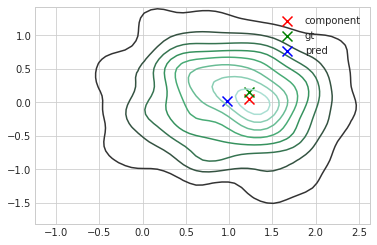

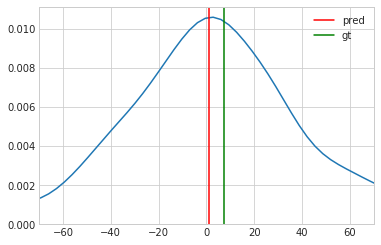

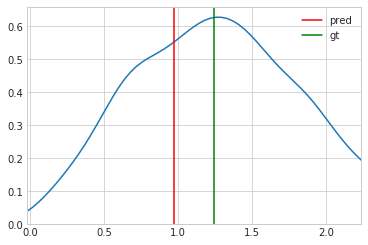

In [10]:
def multivariate_sample(mu_, sigma_):
    #print(sigma_)
    return np.vstack([np.random.multivariate_normal(m, s) for m, s in zip(mu_, sigma_)])

sns.set_style('whitegrid')

model.train()

idx = np.random.randint(low=0,
                        high=len(y_test_np))
print(idx)
import random
#idx = random.choice(np.where(X_test_np[:,36//2-4] == 1)[0])
with torch.no_grad():
    out = model(X_test[:,idx:idx+1,:].to(device))

#to_numpy = lambda o: np.repeat(o.data.cpu().numpy(), n_samples, axis=0)
to_numpy = lambda o: o.squeeze(0).detach().cpu().numpy()
pi, sigma, mu = [to_numpy(o) for o in out]


def compute_covar_matrix(sigma):
    sigma = np.vstack([sigma[:,0], np.zeros_like(sigma[:,0]), sigma[:,1], sigma[:,2]]).T
    sigma = sigma.reshape(-1,2,2)
    sigma = np.matmul(sigma,sigma.transpose(0,2,1))
    return sigma

if covariance_type == 'diagonal':
    sigma = np.stack((np.diag(s) for s in sigma), axis=0)
else:
    sigma = compute_covar_matrix(sigma)

print('Pi:\t ', pi[:],
      '\nSigma:\t ', sigma[:,:],
     '\nMu:\t', mu[:,:])

def gumbel_sample(x, axis=1):
    z = np.random.gumbel(loc=0, scale=1, size=x.shape)
    return (np.log(x) + z).argmax(axis=axis)

def mixture_sample(pi, mu, sigma, n_samples, covar_type='general'):
    assert(covar_type == 'general')
    
    # First sample from component distribution.
    components = gumbel_sample(np.tile(pi,n_samples).reshape(n_samples,-1))

    components, component_samples = np.unique(components, return_counts=True)
    print(components, component_samples)

    samples = []
    for idx, size in zip(components, component_samples):
        # Note that without increased tolerance numpy thinks our matrices aren't positive
        # semidefinit even though they are by construction!
        samples.append(np.random.multivariate_normal(mean=mu[idx],
                                                     cov=sigma[idx],
                                                     size=size,
                                                     check_valid='raise',
                                                     tol=1e-6))
    return np.vstack(samples)

n_samples = 1000
samples = mixture_sample(pi, mu, sigma, n_samples=n_samples)

vectors = torch.tensor(samples).float().numpy()
angles = np.rad2deg(np.apply_along_axis(lambda x: angle_between(np.array([1,0]), x), arr=vectors, axis=1))

vector_hat = vectors.mean(axis=0)
vector_gt = y_test[idx].numpy()
angle_gt = np.rad2deg(angle_between(np.array([1,0]), vector_gt))

kick_length_hat = np.linalg.norm(vectors, axis=1)
kick_length_gt = np.linalg.norm(y_test_np[idx,:])

def get_bounds(a,b, window):
    l = min(a,b) - window
    u = max(a,b) + window
    return l,u
        
fig, ax = plt.subplots()
sns.kdeplot(samples[:,0], samples[:,1], ax=ax)
mu_x, mu_y = np.hsplit(mu[0], [1])
ax.scatter(mu_x, mu_y, c='red', marker='x', s=100, linewidths=4, label='component')
ax.scatter(vector_gt[0], vector_gt[1], c='green', marker='x', s=100, linewidths=4, label='gt')
ax.scatter(vector_hat[0], vector_hat[1], c='blue', marker='x', s=100, linewidths=4, label='pred')

ax.legend()

b_x = np.percentile(a=samples[:,0], q=[1,98])
b_y = np.percentile(a=samples[:,1], q=[1,98])
ax.set_xlim(b_x)
ax.set_ylim(b_y)

fig, ax = plt.subplots()
sns.kdeplot(angles, ax=ax)
pred, gt = np.rad2deg(angle_between(np.array([1,0]), vector_hat)), angle_gt
ax.axvline(x=pred, label='pred', c='red')
ax.axvline(x=gt, label='gt', c='green')
#ax.set_xlim(get_bounds(pred, gt, 20))
ax.set_xlim(-70,70)
ax.legend()

fig, ax = plt.subplots()
sns.kdeplot(kick_length_hat, ax=ax)
pred, gt = np.linalg.norm(vector_hat), kick_length_gt
ax.axvline(x=pred, label='pred', c='red')
ax.axvline(x=gt, label='gt', c='green')
ax.set_xlim(get_bounds(pred, gt, 1))
ax.legend()

In [11]:
idx = 1872, 199

0.43504044 [[0.39584723 0.01440692]
 [0.01440692 0.3311607 ]] [1.2332187  0.05442019]
0.30203605 [[ 1.1091288  -0.10977092]
 [-0.10977092  0.8782498 ]] [0.73398924 0.07597271]
0.26292354 [[0.49225026 0.00807065]
 [0.00807065 0.47365803]] [0.72600275 0.06555884]


(-5, 5)

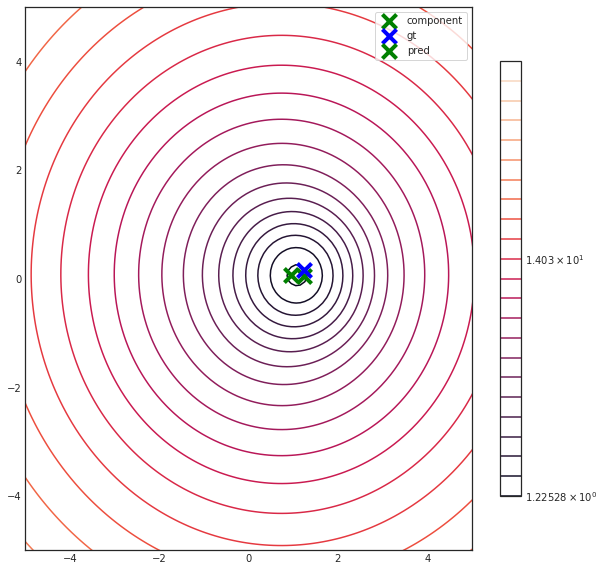

In [12]:
sns.set_style('white')
from scipy import stats
from matplotlib import colors

x = np.linspace(-10,10, num=200)
y = np.linspace(-10,10, num=200)
X, Y = np.meshgrid(x,y)
XX = np.array([X.ravel(), Y.ravel()]).T

Z = np.zeros_like(X)*1.0
mean = np.array([0.,0])
for p, s, m in zip(pi, sigma, mu):
    print(p,s,m)
    # todo: for general matrices
    gaussian = stats.multivariate_normal(mean=m, cov=np.diag(s))
    mean += p*m
    ll = gaussian.pdf(XX)
    ll = ll.reshape(X.shape)
    Z +=  p * ll
    
Z = -np.log(Z)
# todo: fix
Z[Z < 0] = 1e-6

fig, ax = plt.subplots(figsize=(10,10))
vmin, vmax = Z.min(), Z.max()
cs = ax.contour(X,Y,Z, levels=np.logspace(0, 3, num=35), norm=colors.LogNorm(vmin=vmin, vmax=vmax),)
fig.colorbar(cs, shrink=0.8, extend='both')
mu_x, mu_y = np.hsplit(mu[0], [1])
ax.scatter(mu_x, mu_y, c='green', marker='x', s=200, zorder=10, linewidth=4, label='component')
ax.scatter(vector_gt[0], vector_gt[1], c='blue', marker='x', s=200, zorder=10, linewidth=4, label='gt')
ax.scatter(mean[0], mean[1], c='green', marker='x', s=200, zorder=10, linewidth=4, label='pred')

ax.legend(frameon=True)
ax.set_xlim(-5,5)
ax.set_ylim(-5,5)


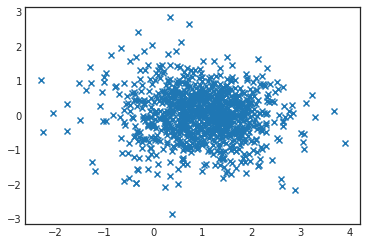

In [13]:
plt.scatter(samples[:,0], samples[:,1], marker='x')